# Importação das bibliotecas

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve, GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin




# Leitura da Base

In [48]:
df = pd.read_csv("/content/drive/MyDrive/PCD1/assets/data/bases_modificadas/State_of_Data_dados_tratados.csv")

# Definição do Atributo alvo

In [49]:
y = df['progressao_prejudicada']
X= df.drop('progressao_prejudicada', axis=1)

# Separação em treino e teste

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [51]:
#======================================================================
# 2. FERRAMENTA DE VERIFICAÇÃO (PROVA DO SMOTE)
#======================================================================
# Vamos criar um passo customizado para o pipeline que imprime informações sobre os dados
class DataChecker(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Não precisa fazer nada no fit

    def transform(self, X, y=None):
        # Imprime o formato e a distribuição das classes dos dados que passam por aqui
        print(f"  > [PROVA SMOTE] Shape dos dados após SMOTE: {X.shape}")
        if y is not None:
            print(f"  > [PROVA SMOTE] Distribuição das classes após SMOTE: {Counter(y)}")
        return X


# CURVA DE APRENDIZAGEM

Gerando Curva de Aprendizagem para diagnóstico inicial...


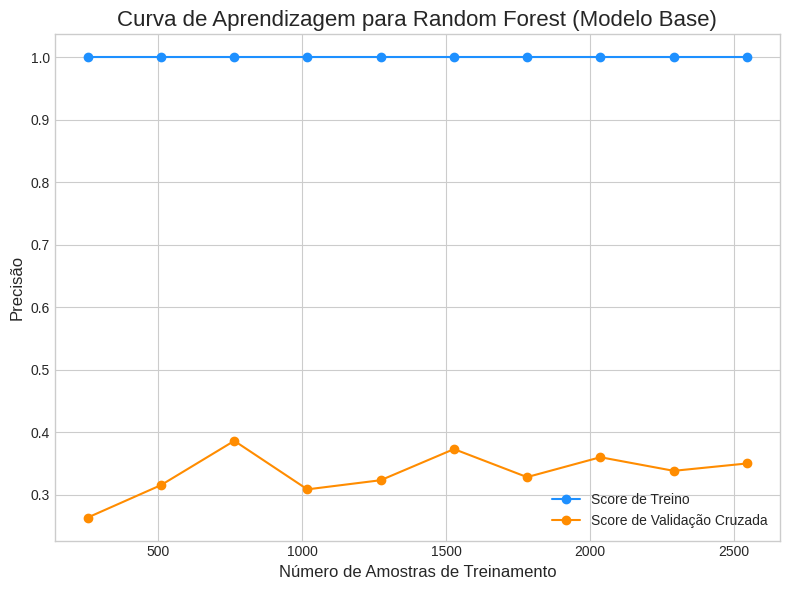

In [52]:
#======================================================================
# 2. DIAGNÓSTICO INICIAL (CURVA DE APRENDIZAGEM)
#======================================================================
# Vamos gerar a curva com um modelo base para entender o comportamento do aprendizado.
# Usamos o pipeline para garantir que o SMOTE seja aplicado corretamente na validação cruzada.
print("Gerando Curva de Aprendizagem para diagnóstico inicial...")
base_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)) # Um modelo padrão
])

train_sizes, train_scores, test_scores = learning_curve(
    estimator=base_pipeline,
    X=X_train, # Usamos apenas os dados de treino para o diagnóstico
    y=y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='precision' # Usando a mesma métrica principal do GridSearch
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='dodgerblue', label='Score de Treino')
plt.plot(train_sizes, test_scores_mean, 'o-', color='darkorange', label='Score de Validação Cruzada')
plt.title('Curva de Aprendizagem para Random Forest (Modelo Base)', fontsize=16)
plt.xlabel('Número de Amostras de Treinamento', fontsize=12)
plt.ylabel('Precisão', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('diagnostico_curva_de_aprendizagem.png')
plt.show()

# Criação da pipeline para evitar vazamento de dados

In [53]:
#======================================================================
# 3. OTIMIZAÇÃO COM GRIDSEARCHCV E PIPELINE
#======================================================================
# Definir o pipeline final para otimização
pipeline_for_grid = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('data_checker', DataChecker()), # Nosso passo de verificação
    ('rf', RandomForestClassifier(random_state=42))
])

# Definir a grade de parâmetros
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

print("\nIniciando Grid Search para encontrar os melhores hiperparâmetros...")
grid_search = GridSearchCV(
    estimator=pipeline_for_grid,
    param_grid=param_grid,
    cv=5,
    scoring='precision',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\nGrid Search concluído.")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print("-" * 50)


Iniciando Grid Search para encontrar os melhores hiperparâmetros...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
  > [PROVA SMOTE] Shape dos dados após SMOTE: (5624, 92)

Grid Search concluído.
Melhores parâmetros encontrados: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
--------------------------------------------------


# Avaliação com Matriz de Confusão

  > [PROVA SMOTE] Shape dos dados após SMOTE: (563, 92)


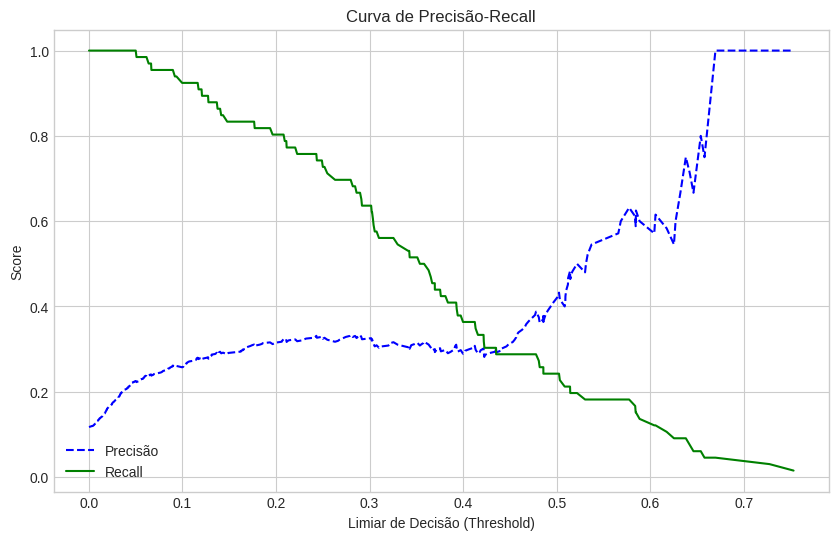


Relatório de Classificação com Novo Limiar:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       497
         1.0       1.00      0.02      0.03        66

    accuracy                           0.88       563
   macro avg       0.94      0.51      0.48       563
weighted avg       0.90      0.88      0.83       563


Matriz de Confusão Final:


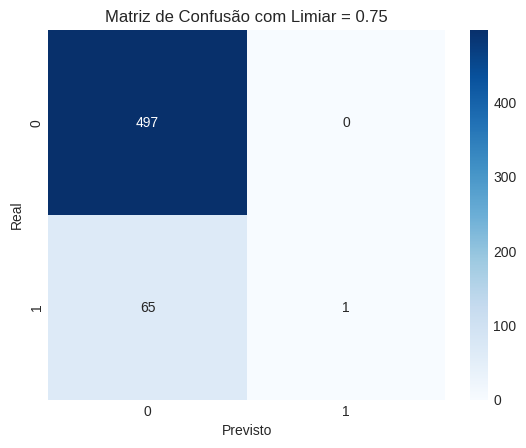

In [58]:
#======================================================================
# 4. AVALIAÇÃO DO MODELO FINAL
#======================================================================
final_model = grid_search.best_estimator_

# PASSO 1: Obtenha as probabilidades de previsão no conjunto de teste
# Precisamos da probabilidade da classe positiva (classe 1)
y_probs = final_model.predict_proba(X_test)[:, 1]

# PASSO 2: Calcule a curva de precisão-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# PASSO 3: Plote a curva para escolher um bom limiar visualmente
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precisão')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.title('Curva de Precisão-Recall')
plt.xlabel('Limiar de Decisão (Threshold)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# PASSO 4: Aplique o novo limiar
novo_limiar = 0.75 # Exemplo: escolha um valor com base no gráfico acima

# Faça as novas previsões com base no limiar customizado
y_pred_novo_limiar = (y_probs >= novo_limiar).astype(int)

print("\nRelatório de Classificação com Novo Limiar:")
print(classification_report(y_test, y_pred_novo_limiar))


# Matriz de Confusão do Teste com o novo limiar
print("\nMatriz de Confusão Final:")
cm = confusion_matrix(y_test, y_pred_novo_limiar)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title(f"Matriz de Confusão com Limiar = {novo_limiar}")
plt.show()








Avaliando o modelo final no conjunto de treino...
  > [PROVA SMOTE] Shape dos dados após SMOTE: (3184, 92)

Relatório de Classificação no Conjunto de Treino:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2812
         1.0       0.97      0.79      0.87       372

    accuracy                           0.97      3184
   macro avg       0.97      0.89      0.93      3184
weighted avg       0.97      0.97      0.97      3184



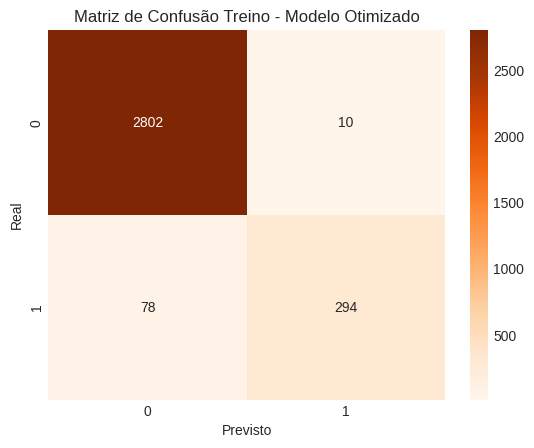

Avaliando o modelo final no conjunto de teste...
  > [PROVA SMOTE] Shape dos dados após SMOTE: (563, 92)

Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       497
         1.0       0.42      0.24      0.31        66

    accuracy                           0.87       563
   macro avg       0.66      0.60      0.62       563
weighted avg       0.85      0.87      0.86       563



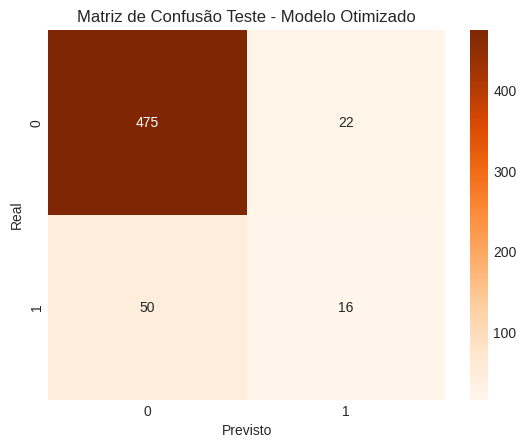

In [55]:
print("Avaliando o modelo final no conjunto de treino...")
y_pred_train = final_model.predict(X_train)

print("\nRelatório de Classificação no Conjunto de Treino:")
print(classification_report(y_train, y_pred_train))

# Matriz de Confusão do Treino
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão Treino - Modelo Otimizado")
plt.show()


















print("Avaliando o modelo final no conjunto de teste...")
y_pred_test = final_model.predict(X_test)

print("\nRelatório de Classificação no Conjunto de Teste:")
print(classification_report(y_test, y_pred_test))

# Matriz de Confusão do Teste
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão Teste - Modelo Otimizado")
plt.show()



Extraindo a importância das features do modelo final...
As 20 Features Mais Importantes (extraídas do Pipeline):
                                              Feature  Importance
4                                    Genero_Masculino    0.171891
3                                     Genero_Feminino    0.148858
6                               Cor/raca/etnia_Branca    0.062476
11                               Cor/raca/etnia_Preta    0.051873
17                           Regiao onde mora_Sudeste    0.033240
18                               Regiao onde mora_Sul    0.028010
9                                Cor/raca/etnia_Parda    0.026120
28  Area de Formação_Computação / Engenharia de So...    0.024844
0                                               Idade    0.024287
59               Setor_Tecnologia/Fábrica de Software    0.023249
65               Cargo_Analista de Dados/Data Analyst    0.021407
36         Situação atual de Trabalho_Empregado (CLT)    0.020548
84           Forma de Trabal

<ipython-input-56-4254605434>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')


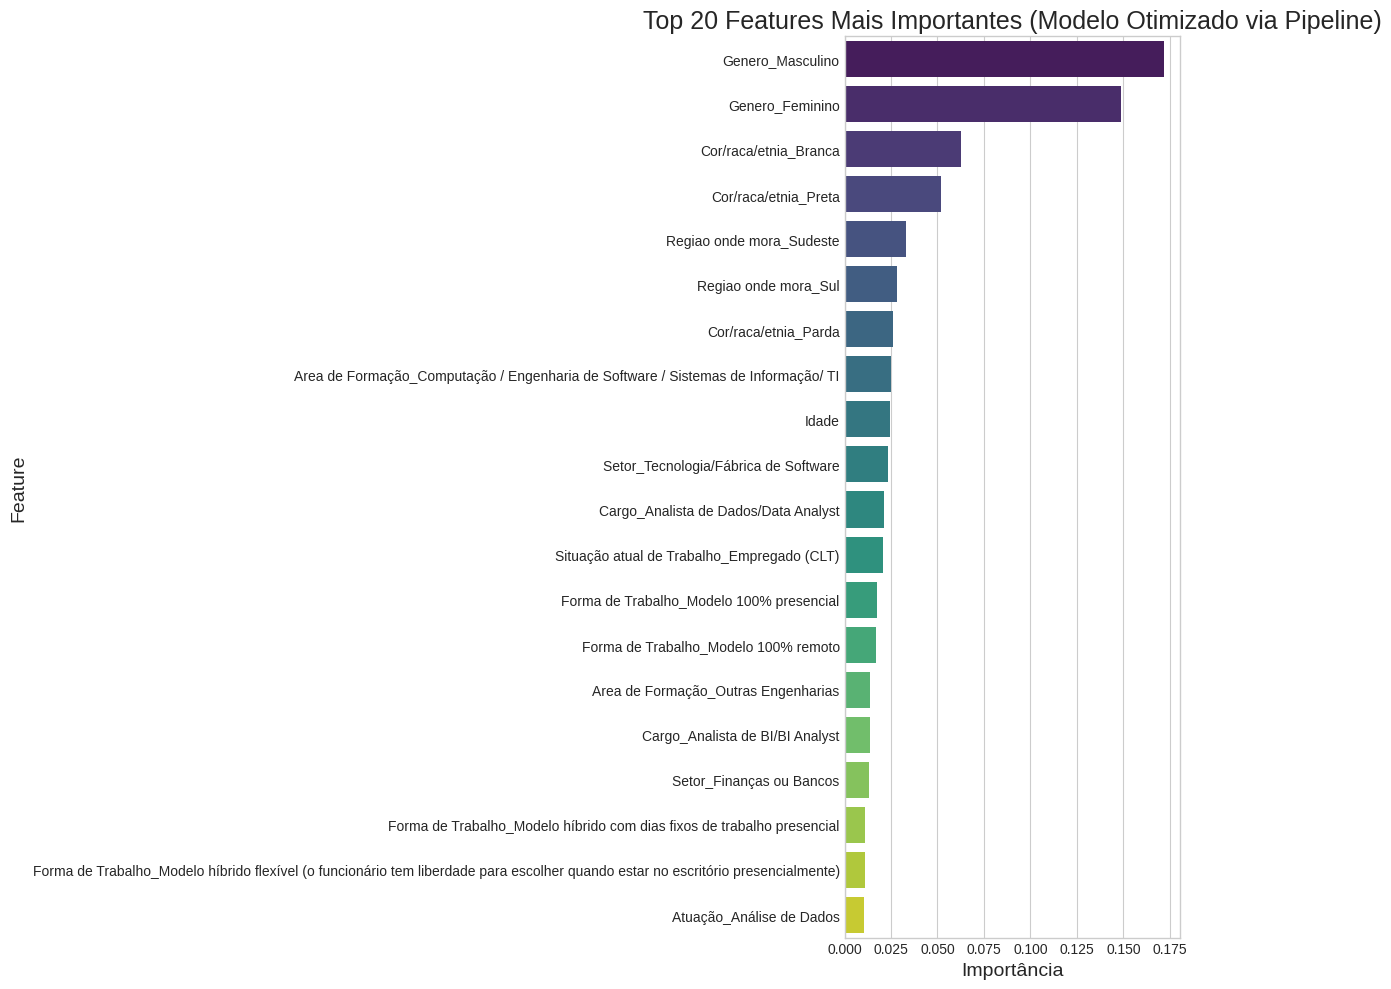

In [56]:
#======================================================================
# 5. ANÁLISE DE IMPORTÂNCIA DAS FEATURES
#======================================================================
print("\nExtraindo a importância das features do modelo final...")
# Acessar o passo do modelo RandomForest DENTRO do pipeline
rf_step = final_model.named_steps['rf']
importances = rf_step.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

print("As 20 Features Mais Importantes (extraídas do Pipeline):")
print(top_20_features)

# Gerar o gráfico
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Features Mais Importantes (Modelo Otimizado via Pipeline)', fontsize=18)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()